**Group Members**

- Prajwal Luitel (C0927658)
- Rajan Ghimire (C0924991)
- Shishir Mishra (C0927250)
- Aarjeyan Shrestha (C0927422)
- Sudip Chaudhary (C0922310)

About the dataset: 

| Column  | Description                                                      | Values (Categorical)                                     |
|---------|------------------------------------------------------------------|---------------------------------------------|
| id      | Unique id for each patient                                       |                                             |
| age     | Age of the patient in years                                      |                                           |
| origin  | Place of study                                                   |Cleveland, Hungary, Switzerland, VA Long Beach                                             |
| sex     | Male/Female                                                      |Male, Female                                             |
| cp      | Chest pain type                                                  | Typical Angina, Atypical Angina, Non-Anginal, Asymptomatic|
| trestbps| Resting blood pressure (in mm Hg on admission to the hospital)   |                                             |
| chol    | Serum cholesterol in mg/dl                                       |                                             |
| fbs     | Fasting blood sugar (> 120 mg/dl)                                |                                             |
| restecg | Resting electrocardiographic results                             | Normal, ST-T Abnormality, LV Hypertrophy    |
| thalach | Maximum heart rate achieved                                      |                                             |
| exang   | Exercise-induced angina (True/False)                             | True, False                                 |
| oldpeak | ST depression induced by exercise relative to rest               |                                             |
| slope   | Slope of the peak exercise ST segment                            |                                             |
| ca      | Number of major vessels (0-3) colored by fluoroscopy             | 0, 1, 2, 3                                  |
| thal    | Thalassemia                                                      | Normal, Fixed Defect, Reversible Defect    |
| num     | Predicted attribute                                              |0, 1, 2, 3, 4                                             |


# Code

In [1]:
import pandas as pd 
import missingno as msno

In [2]:
df = pd.read_csv("heart_disease_uci.csv")
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## Handelling missing values

<Axes: >

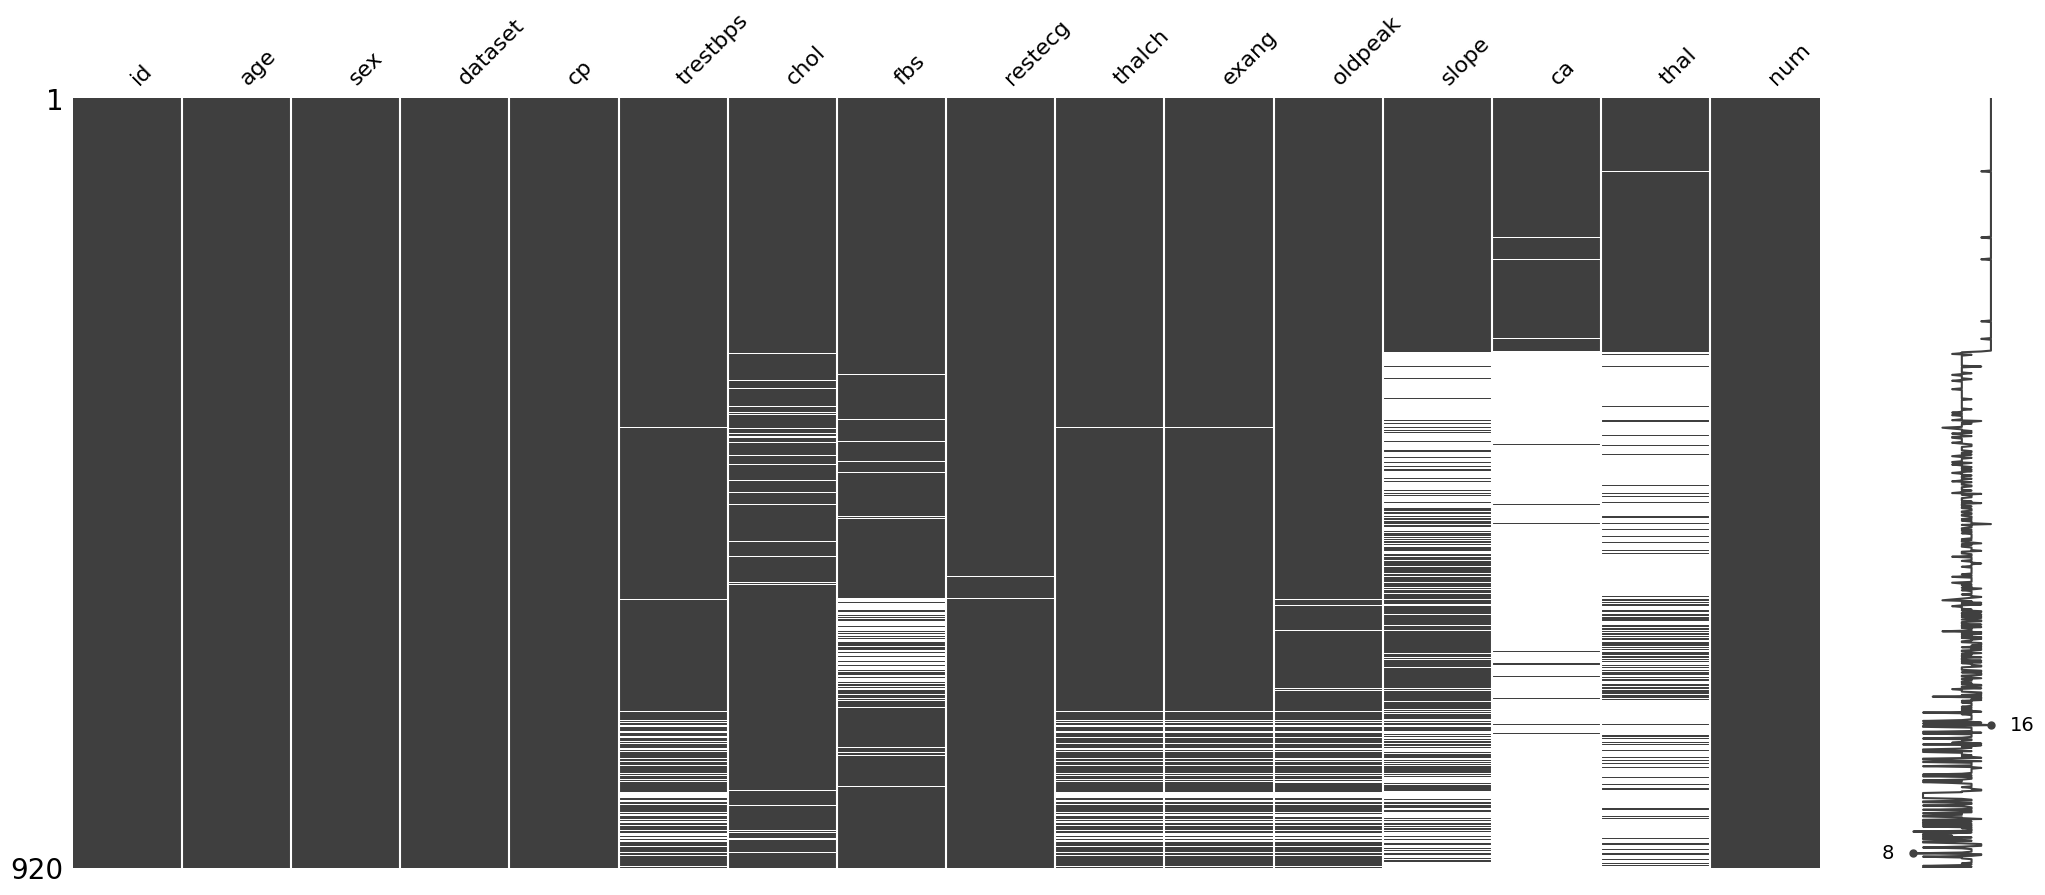

In [3]:
# get all columns with missing values.

col_mis_val = df.columns[df.isnull().sum() > 0]
col_mis_val = col_mis_val.to_list()

# visualize missing values with missingno.

msno.matrix(df)

**Data Completeness per missing values**

<Axes: >

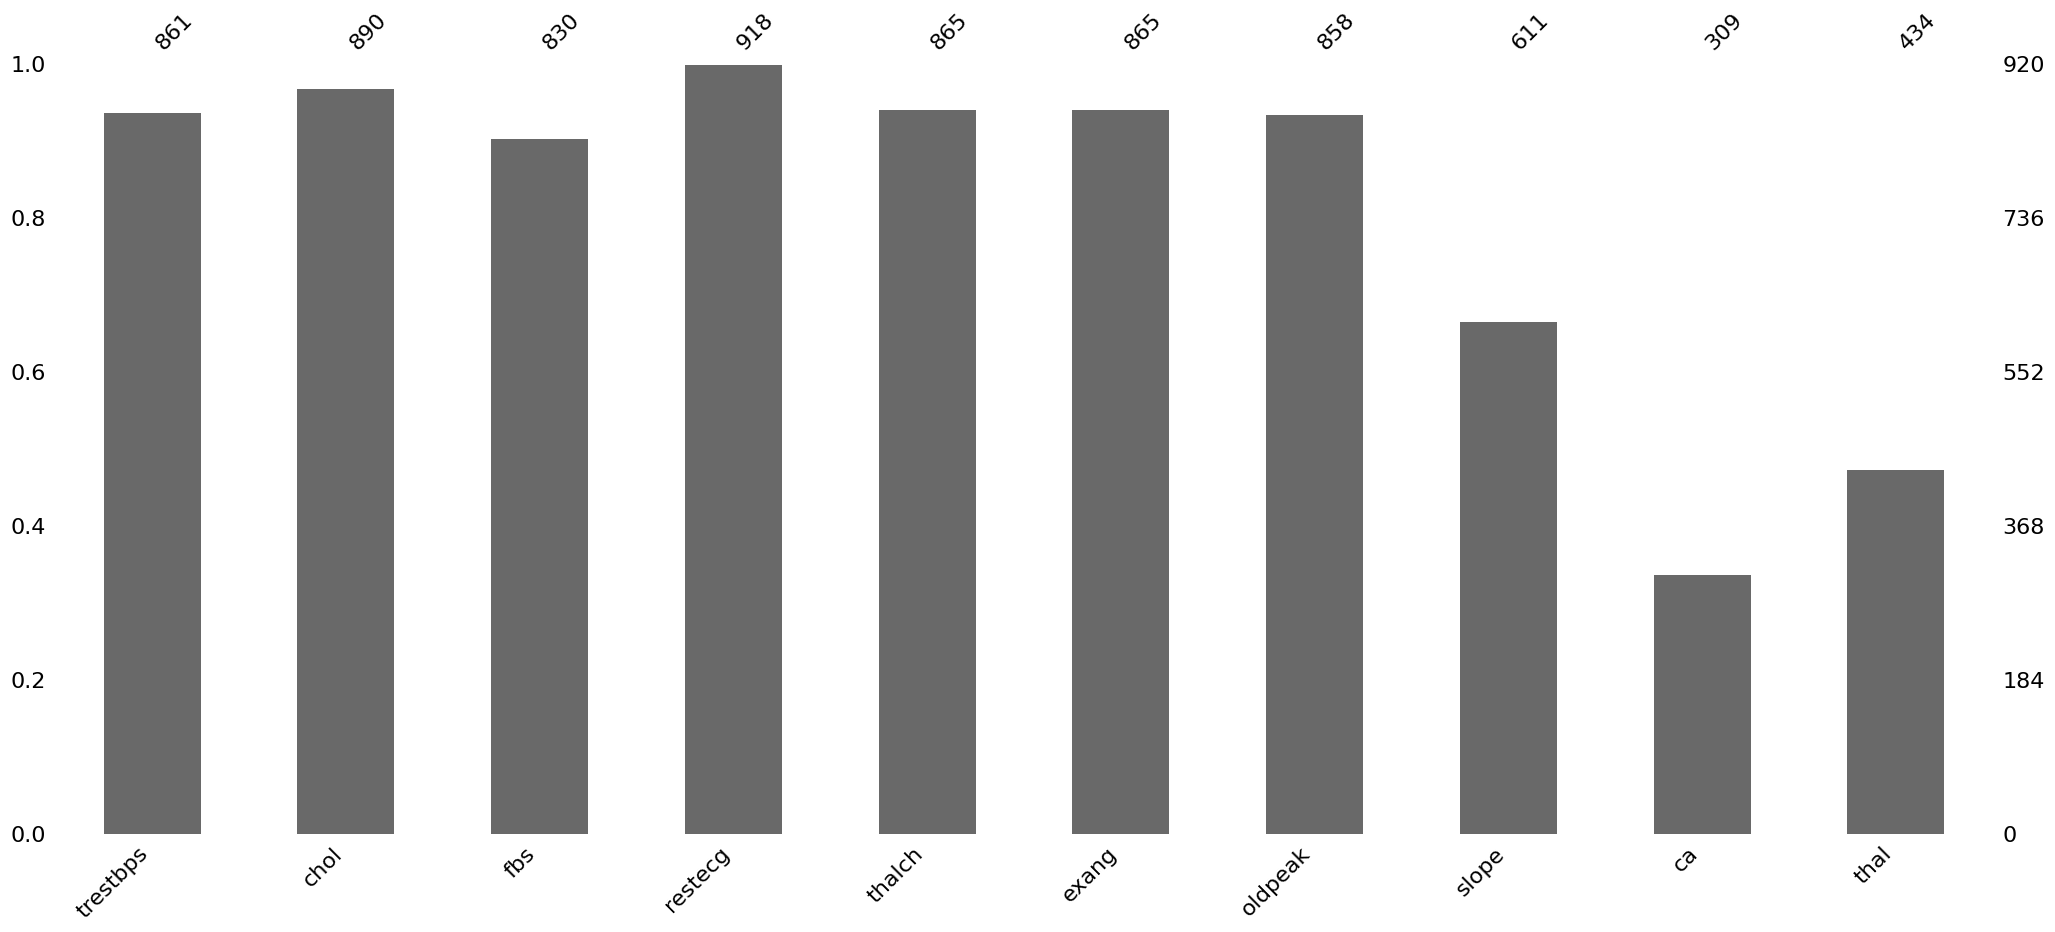

In [4]:
msno.bar(df[col_mis_val])

In [5]:

print("Percentage of missing values in each column")
feature_percent = round(((df.isnull().sum() / len(df)) * 100 ).sort_values(ascending=False),2)

# add % sympbol
feature_percent = feature_percent.astype(str) + '%'
feature_percent

Percentage of missing values in each column


ca          66.41%
thal        52.83%
slope       33.59%
fbs          9.78%
oldpeak      6.74%
trestbps     6.41%
thalch       5.98%
exang        5.98%
chol         3.26%
restecg      0.22%
id            0.0%
age           0.0%
sex           0.0%
dataset       0.0%
cp            0.0%
num           0.0%
dtype: object

#### 🔍Findings🔍
- Missing values in 10 columns 
- 7 features in which the percentage of missing data is less than 10%
- 3 features ['slope', 'thal', 'ca'] in which the percentaage of missing data is high (Around 33%, 52%, and 66% respectively).
- Missing values in both numerical and categorical features

In [6]:
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
classifier_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
regressor_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error


import warnings 
warnings.filterwarnings("ignore")

**Handeling Missing values**

Our approach: 

![](mermaid-flow.png)

In [8]:
def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    # print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    # print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]


In [9]:
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in classifier_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in regressor_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values trestbps : 6.41%
MAE = 13.281445086705205 

Missing Values chol : 3.26%
MAE = 45.501516853932586 

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 78.92 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 65.76 accuracy

Missing Values thalch : 5.98%
MAE = 16.752890173410403 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 79.19 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.5653372093023257 

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 67.48 accuracy

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 62.9 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 68.97 accuracy



## EDA

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def numerical_features_visualizations(col, df):
    # custom_color = "#6da34e"
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"BoxPlot of '{col}'", f"HistPlot of '{col}'"))

    fig.add_trace(go.Box(y=df[col], name=col), row=1, col=1)

    fig.add_trace(go.Histogram(x=df[col], name=col, ), row=1, col=2)
    
    fig.update_layout(
        title_text=f"Visualizations for {col}",
        showlegend=False,
        plot_bgcolor='black',  
        paper_bgcolor='black',  
        font=dict(color='white'),
        height = 600,
        xaxis=dict(showgrid=False),  # Hide x-axis grid lines for the first plot
        yaxis=dict(showgrid=False),  # Hide y-axis grid lines for the first plot



    )
    # Show plot
    fig.show()


for col in regressor_cols:
    numerical_features_visualizations(col, df)


#### Analysis on Sex and Age

In [11]:
plot_df = df['sex'].value_counts().reset_index()
fig = go.Figure(data=[go.Pie(labels=plot_df['sex'], values=plot_df['count'], hole=0.5)])


fig.update_layout(
        title_text=f"Gender Distribution",
        showlegend=True,
        annotations=[dict(text='Gender', x=0.5, y=0.5, font_size=20, showarrow=False)],
        plot_bgcolor='black',  
        paper_bgcolor='black',  
        font=dict(color='white'),
        height = 600,
        xaxis=dict(showgrid=False),  # Hide x-axis grid lines for the first plot
        # yaxis=dict(showgrid=False),  # Hide y-axis grid lines for the first plot

    )

# Show plot
fig.show()


In [12]:
fig = px.histogram(data_frame=df, x="age", color="sex")
fig.update_layout(
        title_text=f"Age column vs Sex column",
        showlegend=True,
        plot_bgcolor='black',  
        paper_bgcolor='black',  
        font=dict(color='white'),
        height = 600,
        xaxis=dict(showgrid=False),  # Hide x-axis grid lines for the first plot
        # yaxis=dict(showgrid=False),  # Hide y-axis grid lines for the first plot

    )
fig.show()

In [33]:
fig = go.Figure()

fig.add_trace(go.Box(y=df['trestbps'].values, name='BP at Rest for all', marker_color='green', boxmean='sd'))
fig.add_trace(go.Box(y=df[df['sex']=='Male']['trestbps'].values, name='Male only', marker_color='blue', boxmean='sd'))
fig.add_trace(go.Box(y=df[df['sex']=='Female']['trestbps'].values, name='Female only', marker_color='red', boxmean='sd'))

fig.update_layout(
    title='BP Distribution in Sex',
    yaxis_title='Blood Pressure (mm/Hg)',
    title_x=0.5,
    paper_bgcolor='black',  
    plot_bgcolor='black',  
    font=dict(color='white'),  
    xaxis=dict(
        showline=True,
        linewidth=2,
        linecolor='white',  
        mirror=True
    ),
    yaxis=dict(
        showline=True,
        linewidth=2,
        linecolor='white',  
        mirror=True,
        gridcolor='gray'
    ),
    height = 800, 
    width = 1200)

fig.show()

In [40]:
pie_data = df['cp'].value_counts().reset_index()
pie_data.rename(columns={'index': 'cp'}, inplace=True)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "xy"}]],
                    subplot_titles=("Chest Pain Conditions", "Count of 'cp' by 'sex'"))

fig.add_trace(
    go.Pie(labels=pie_data['cp'], values=pie_data['count'], hole=0.5),
    row=1, col=1
)

fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15,
                  insidetextorientation='radial', row=1, col=1)

bar_fig = px.bar(df, x='cp', color='sex', barmode='group', category_orders={"sex": ["Male", "Female"]})
for trace in bar_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    title_text="Chest Pain Conditions Analysis",
    showlegend=True,
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    height=600
)

# Show the figure
fig.show()

In [44]:
pie_data = df['restecg'].value_counts().reset_index()
pie_data.rename(columns={'index': 'restecg'}, inplace=True)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "xy"}]],
                    subplot_titles=("restecg categories", "Count of 'restecg' by 'sex'"))

fig.add_trace(
    go.Pie(labels=pie_data['restecg'], values=pie_data['count'], hole=0.5),
    row=1, col=1
)

fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15,
                  insidetextorientation='radial', row=1, col=1)

bar_fig = px.bar(df, x='restecg', color='sex', barmode='group', category_orders={"sex": ["Male", "Female"]})
for trace in bar_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    title_text="restecg analysis",
    showlegend=True,
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    height=600
)

# Show the figure
fig.show()

In [46]:
pie_data = df['exang'].value_counts().reset_index()
pie_data.rename(columns={'index': 'exang'}, inplace=True)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "xy"}]],
                    subplot_titles=("Exercise-induced angina categories", "Count of 'exang' by 'sex'"))

fig.add_trace(
    go.Pie(labels=pie_data['exang'], values=pie_data['count'], hole=0.5),
    row=1, col=1
)

fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15,
                  insidetextorientation='radial', row=1, col=1)

bar_fig = px.bar(df, x='exang', color='sex', barmode='group', category_orders={"sex": ["Male", "Female"]})
for trace in bar_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    title_text="Exercise-induced angina analysis per Sex",
    showlegend=True,
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    height=600
)

# Show the figure
fig.show()

**Is any correlation or pattern between the type of chest pain ('cp' variable) and the maximum heart rate achieved ('thalch' variable) with respect to outcome('num' variable)**

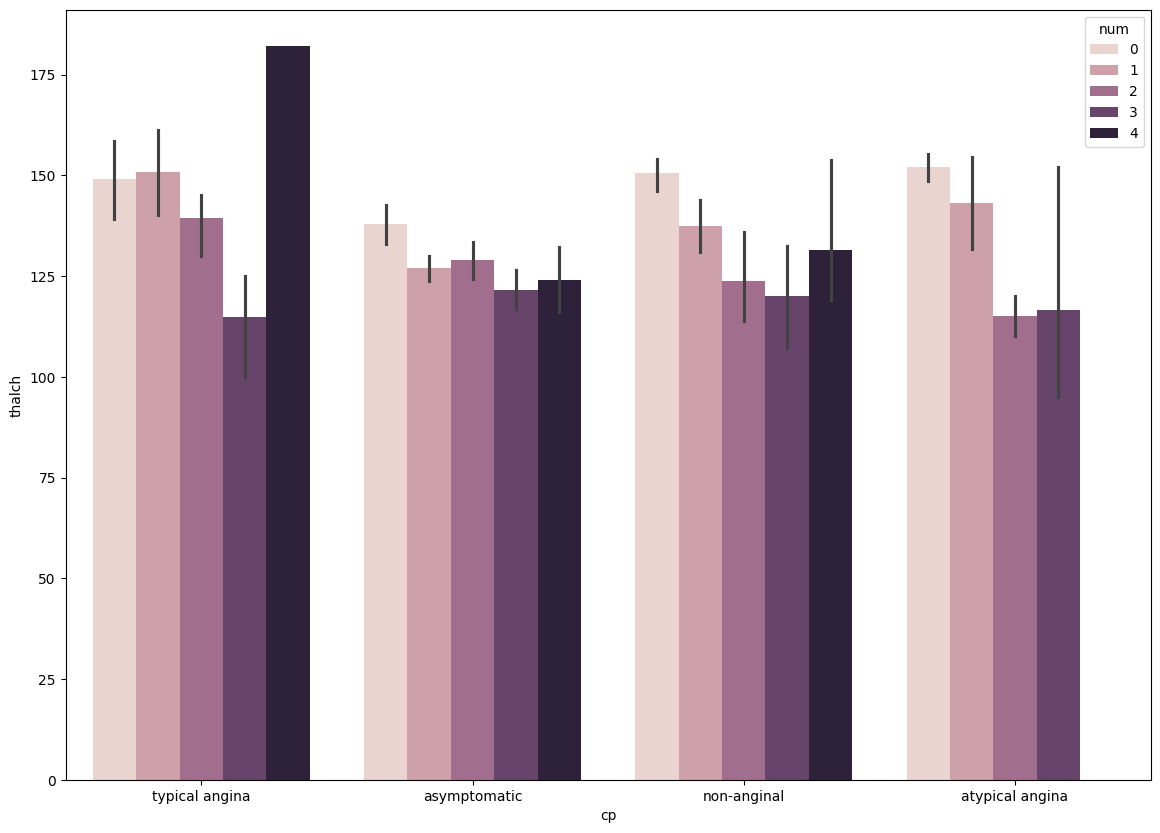

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
sns.barplot(data = df,
               x = 'cp',
               y = 'thalch',
               hue = 'num')
plt.show()


**Relationship between Maximum heart rate achived and Heart Disease Severity**

In [81]:

from sklearn.linear_model import LinearRegression

# Fit linear models
model_thalch = LinearRegression().fit(df[['thalch']], df['num'])
df['thalch_pred'] = model_thalch.predict(df[['thalch']])

fig_thalch = px.scatter(df, x='thalch', y='num', opacity=0.65,
                          title='Relationship between Maximum heart rate achived and Heart Disease Severity',
                          labels={'num': 'Heart Disease Severity', 'thalch': 'Maximum heart rate achived.'})


fig_thalch.add_trace(go.Scatter(x=df['thalch'], y=df['thalch_pred'], mode='lines',
                                  name='Regression Line', line=dict(color='red')))

fig_thalch.update_layout(
    height=800
)

fig_thalch.show()



**t-SNE Visualization of Heart Disease Data: Clustering by Disease Severity**

In [67]:

from sklearn.manifold import TSNE

X = df[regressor_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Heart Disease Severity'] = df['num'] 

# Plot
fig = px.scatter(tsne_df, x='Dim1', y='Dim2', color='Heart Disease Severity',
                 color_continuous_scale=px.colors.sequential.Viridis,
                 labels={'Dim1': 'Dimension 1', 'Dim2': 'Dimension 2'},
                 title='t-SNE visualization of Heart Disease Data')

fig.update_layout(height=800)
fig.show()


In [69]:
X = df[regressor_cols]  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
tsne_df['Heart Disease Severity'] = df['num']  
# Plot in 3D
fig = px.scatter_3d(tsne_df, x='Dim1', y='Dim2', z='Dim3', color='Heart Disease Severity',
                    color_continuous_scale=px.colors.sequential.Viridis,
                    labels={'Dim1': 'Dimension 1', 'Dim2': 'Dimension 2', 'Dim3': 'Dimension 3'},
                    title='3D t-SNE Visualization of Heart Disease Data')

fig.update_layout(height=800)
fig.show()
